In [ ]:
devtools::load_all()
setwd("../")

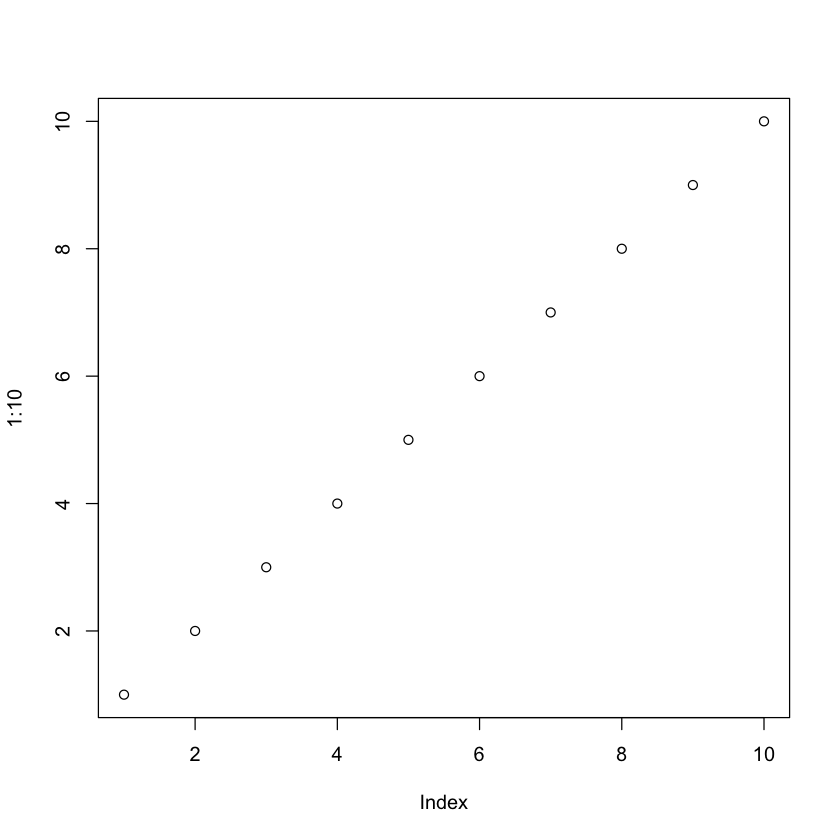

In [1]:
par(bg = "white")
plot(1:10)

In [ ]:
tedf <- TEDF$new("tech/Electrolysis")$load()
tedf$data

In [ ]:
 DataSet$new('Tech|Electrolysis')$normalise(override=list('Tech|Electrolysis|Input Capacity|elec'= 'kW', 'Tech|Electrolysis|Output Capacity|h2'= 'kW;LHV'))  %>% filter(source=='Vartiainen22')

In [ ]:
DataSet$new('Tech|Electrolysis')$normalise(override=list('Tech|Electrolysis|Output Capacity|h2'= 'kW;LHV'))

In [ ]:
DataSet$new('Tech|Electrolysis')$select(period=2020, subtech='AEL', size='100 MW', override=list('Tech|Electrolysis|Output Capacity|h2'= 'kW;LHV'))

In [ ]:
DataSet$new('Tech|Electrolysis')$select(period=2030, source='Yates20', subtech='AEL', size='100 MW', override={'Tech|Electrolysis|Output Capacity|h2'= 'kW;LHV'}, extrapolate_period=FALSE)

In [ ]:
DataSet$new('Tech|Electrolysis')$select(subtech=c('AEL', 'PEM'), size='100 MW', override={'Tech|Electrolysis|Input Capacity|Electricity'= 'kW'})

In [ ]:
DataSet$new('Tech|Electrolysis')$aggregate(subtech='AEL', size='100 MW', agg='subtech', override={'Tech|Electrolysis|Output Capacity|Hydrogen'='kW;LHV'})

In [ ]:
# DataSet$new('Tech|Methane Reforming')$aggregate(period=2030).query("variable.str.contains('OM Cost')"))
# display(DataSet('Tech|Methane Reforming').aggregate(period=2030).query("variable.str.contains('Demand')"))
DataSet$new('Tech|Methane Reforming')$aggregate(period=2030) %>% arrange(variable)

In [ ]:
DataSet$new('Tech|Direct Air Capture')$normalise()

In [ ]:
DataSet$new('Tech|Direct Air Capture')$select()

In [ ]:
TEDF$new('Tech|Haber-Bosch with ASU')$load()# $check()
DataSet$new('Tech|Haber-Bosch with ASU')$normalise()

In [ ]:
DataSet$new('Tech|Haber-Bosch with ASU')$select(period=2020)

In [ ]:
DataSet$new('Tech|Haber-Bosch with ASU')$aggregate(period=2020)